# 1. Importing Libraries 

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 2. Importing Data

In [2]:
#Configuring the API key 
quandl.ApiConfig.api_key = '2JamcDHsnboes3x_oW-f'

In [3]:
# Importing The S&P 500 Ratios Data "Price to Sales Ratio by Quarter" variable.
data = quandl.get('MULTPL/SP500_PSR_QUARTER')

In [4]:
#Checking the data
data.head()

,Value
Date,
2000-12-31,1.77
2001-03-31,1.54
2001-06-30,1.64
2001-09-30,1.41
2001-12-31,1.56


In [5]:
#Checking shape of the data
data.shape

(144, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

# 3. Subsetting, wrangling, and cleaning time-series data

In [8]:
# Reseting the index to use the "Date" column as a filter
data_2= data.reset_index()

In [9]:
data_2.head()

,Date,Value
0,2000-12-31,1.77
1,2001-03-31,1.54
2,2001-06-30,1.64
3,2001-09-30,1.41
4,2001-12-31,1.56


In [10]:
#Creating a subset data
data_sub = data_2.loc[(data_2['Date'] >= '2009-07-01') & (data_2['Date'] < '2022-10-01')]

In [11]:
#Setting the "Date" column as the index
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
2009-09-30,1.17
2009-12-31,1.23
2010-03-31,1.27
2010-06-30,1.11
2010-09-30,1.21


### I selected my datapoint  in this way because of the latest U.S. recession—which began in December 2007 and ended in June 2009— This was the longest (18 months) and deepest (about a 3.7 percent decline in output) the country has experienced since 1960. I didn't want that decline to bias my analysis

# 4. Creating a line chart for the data

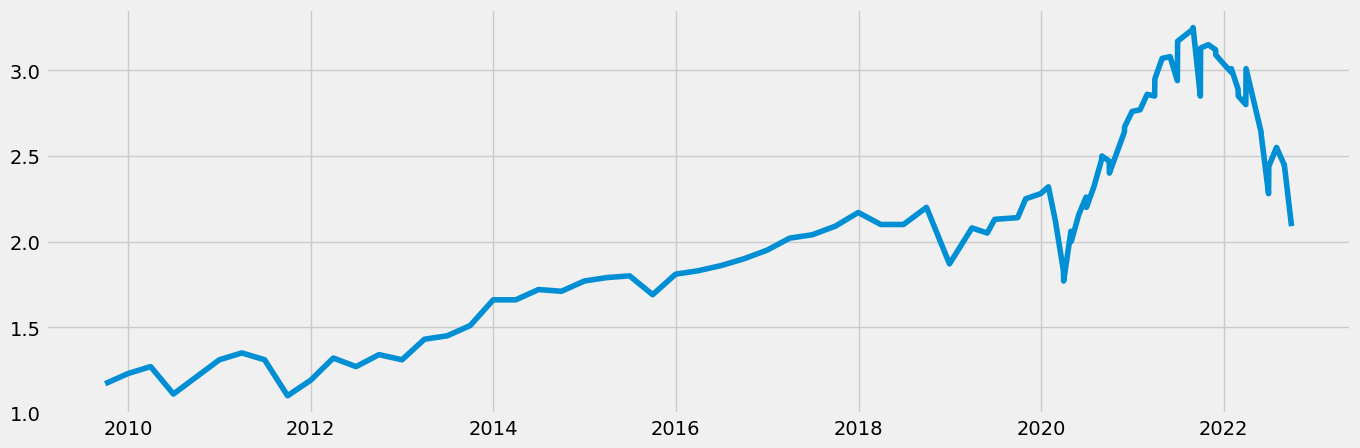

In [12]:
# Plotting the new subset data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [13]:
# Checking for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [14]:
# Checking for duplicates
dups = data_sub.duplicated()
dups.sum()

16

In [15]:
#Dropping duplicates
data_sub.drop_duplicates(inplace=True)

In [16]:
# Checking for duplicates
dups = data_sub.duplicated()
dups.sum()
# No dups!

0

# 5. Decomposing the data’s components.

In [17]:
# Decompose the time series using an additive model and setting the frequency
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=4)

In [18]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

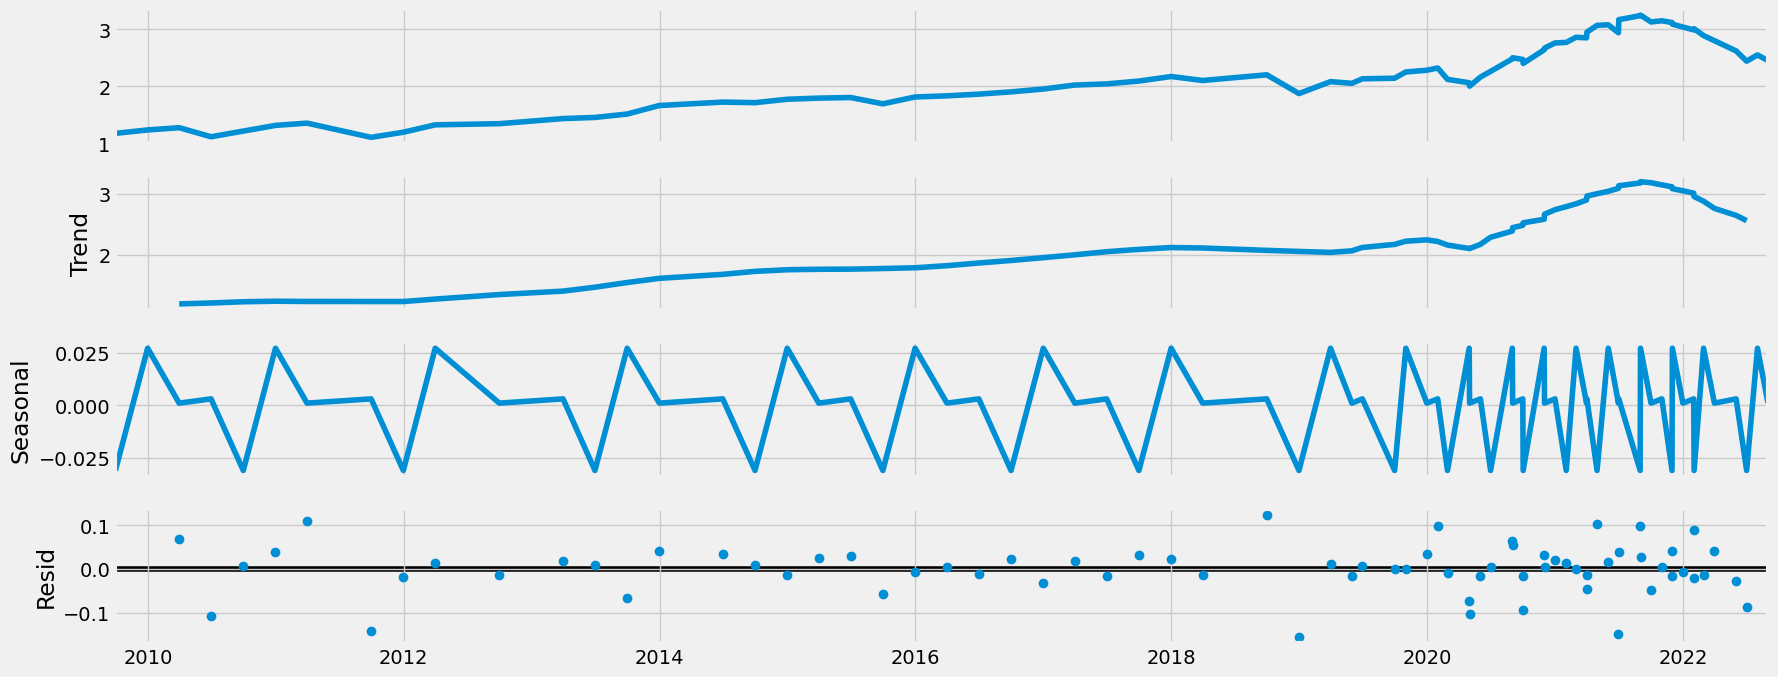

In [19]:
# Plotting the separated components
decomposition.plot()
plt.show()

## Results
###### The trend slightly differs from the level, this indicates that the data could need to be smoothen as it could have  noise in it.
###### We do have seasonality in our data as indicated in the plot.
###### As suspected, we do have some noise in our data.
###### The presence of a trend and seasonality implies the series is non-stationary

# 6. Conducting a Dickey-Fuller test to check for stationarity.

In [20]:
# Importing the adfuller() function
from statsmodels.tsa.stattools import adfuller 
#Defining the function
def dickey_fuller(timeseries): 
    # Performing the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.629928
p-value                         0.467529
Number of Lags Used             0.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


## All significance levels are smaller than the test statistic. 
## This indicates that I can’t reject the null hypothesis.
#### The “Critical Value (5%)” has a value of -2.901470. This is smaller than the test statistic, which is -1.629928.
#### The “Critical Value (10%)” has a value of -2.588072. This is smaller than the test statistic, which is -1.629928.

# 7. Conducting a round of differencing 

In [21]:
#Conducting differencing
data_diff = data_sub - data_sub.shift(1)

In [22]:
# Checking for missing values
data_diff.isnull().sum() 

Value    1
dtype: int64

In [23]:
#Removing the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True)

In [24]:
#Checking the data
data_diff.head()

,Value
datetime,
2009-12-31,0.06
2010-03-31,0.04
2010-06-30,-0.16
2010-09-30,0.10
2010-12-31,0.10


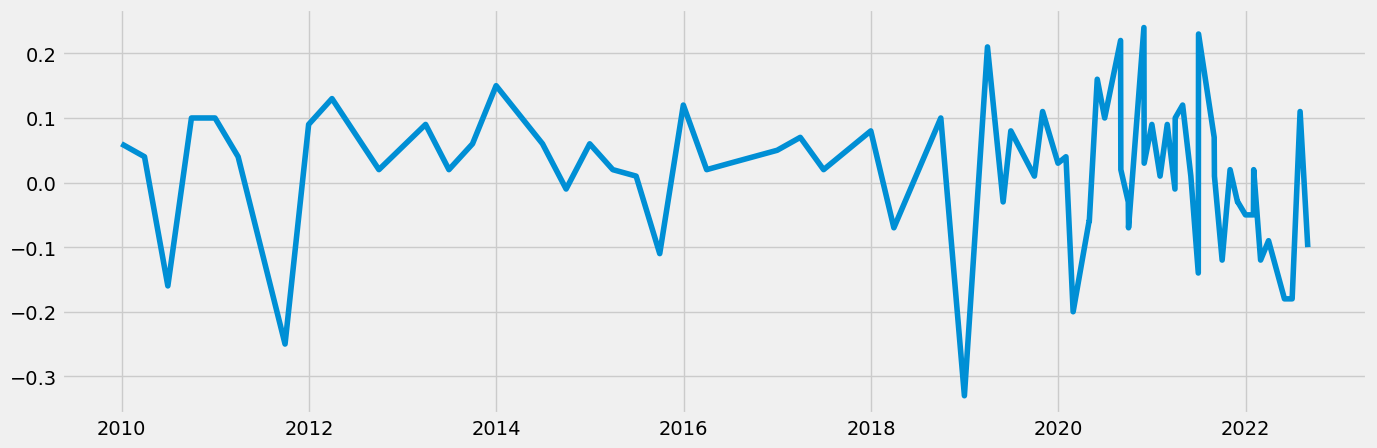

In [25]:
# Checking out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
# Performing the Dickey-Fuller test:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.506149
p-value                         0.000002
Number of Lags Used             1.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


###### The test statistic is now smaller than the critical value at both the 5% Critical Value and 10% Critical Value significance levels. The p-value of  (p<0.05) is also satisfactory. In conculsion, I can reject the null hypothesis and consider my series stationary. The stationarity is very strong

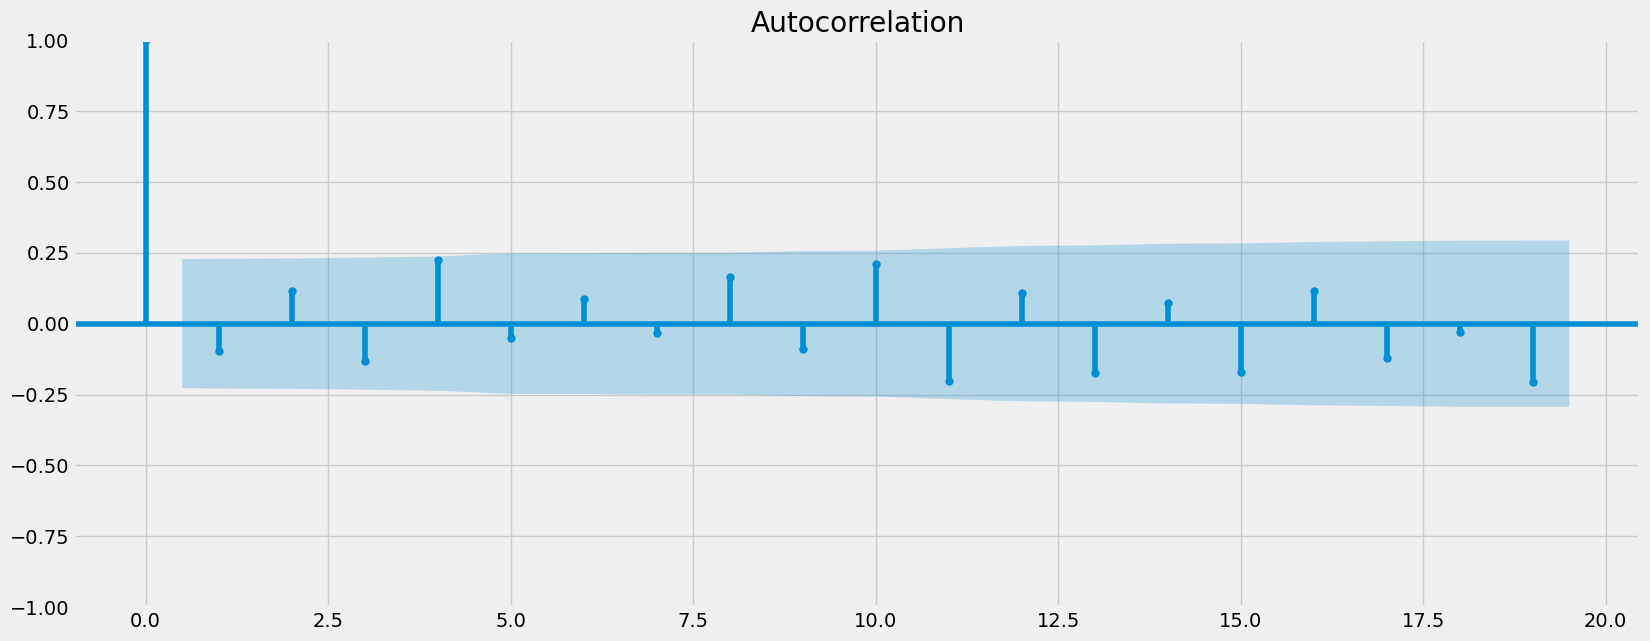

In [27]:
# Checking out a plot of autocorrelations
plot_acf(data_diff)
plt.show()

### I only have One significant lag, therefore a second round of differencing will not be necessary.